# Pytorch quickstart for beginners

This short introduction uses [Pytorch](https://pytorch.org/) to:

1. Build a neural network that classifies images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.
4. Save the model as pt format
5. Convert the model to onnx model

 To run this notebook, please install pytorch, jupyter, matplotplib and numpy
```
pip install torch==1.6.0
pip install jupyter
pip install matplotplib
pip install numpy
```
Use your terminal to launch the notebook by executing "jupyter notebook". You should be able to see your browser running notebook's server. Open this tutorial by clicking MNIST_Keras_tutorial.ipynb and clicking the tab "Cell/Run All" to see the result. Download and install TensorFlow 2. Import TensorFlow into your program:Note: Upgrade pip to install the TensorFlow 2 package. See the install guide for details.

In [1]:
from __future__ import print_function
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Download [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and prepare dataloaders.

In [2]:
use_cuda = False

torch.manual_seed(123)

device = "cpu"
batch_size = 64
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}

transform = transforms.Compose(
    [transforms.ToTensor()])
# Work around for HTTP Error 503 during MNIST dataset downloading
if not os.path.isdir("MNIST"):
    if not os.path.isfile("./MNIST.tar.gz"):
        os.system(
            "wget www.di.ens.fr/~lelarge/MNIST.tar.gz --no-check-certificate")
    os.system("tar -zxvf MNIST.tar.gz")

dataset1 = datasets.MNIST('./', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./',
                          train=False,
                          download=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Visualize the dataset 

In [3]:
x_train, y_train = next(iter(train_loader))
x_train = torch.squeeze(x_train, dim=1)
print(x_train.shape)

torch.Size([64, 28, 28])


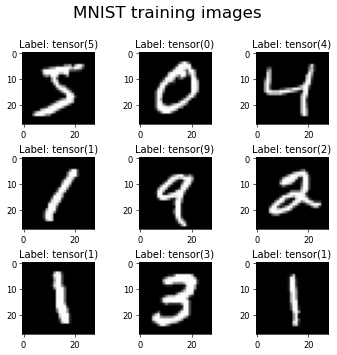

In [4]:
import numpy as np
import matplotlib.pyplot as plt

width=4
height=4
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(6, 6), dpi=60)

for i in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Label: "+str(y_train[i]))
    axes[-1].set_title(subplot_title, fontsize=12)  
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
fig.tight_layout()
fig.suptitle('MNIST training images', fontsize=20)
plt.subplots_adjust(top=0.85)
plt.show()

Build the model by stacking layers. Choose an optimizer and loss function for training:

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.drop_out1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop_out1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


Define train/test code

In [6]:
training_loss_history = []
testing_loss_history = []
training_acc_history = []
testing_acc_history = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(
                dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    training_loss_history.append(loss)
    acc = correct/len(train_loader.dataset)
    training_acc_history.append(acc)
    
    print('Train Epoch: {} \tLoss: {:.6f} \tAcc: {:.6f}'.format(
          epoch, loss.item(), acc))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,
                                    reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    testing_loss_history.append(test_loss)
    acc = correct / len(test_loader.dataset)
    testing_acc_history.append(acc)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * acc))

In [7]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    optimizer.step()

Train Epoch: 0 	Loss: 0.080999 	Acc: 0.891683

Test set: Average loss: 0.2021, Accuracy: 9387/10000 (94%)

Train Epoch: 1 	Loss: 0.030368 	Acc: 0.943817

Test set: Average loss: 0.1353, Accuracy: 9590/10000 (96%)

Train Epoch: 2 	Loss: 0.018999 	Acc: 0.958800

Test set: Average loss: 0.1075, Accuracy: 9663/10000 (97%)

Train Epoch: 3 	Loss: 0.019691 	Acc: 0.966833

Test set: Average loss: 0.0941, Accuracy: 9711/10000 (97%)

Train Epoch: 4 	Loss: 0.016614 	Acc: 0.971333

Test set: Average loss: 0.0861, Accuracy: 9736/10000 (97%)



Plot the history of training

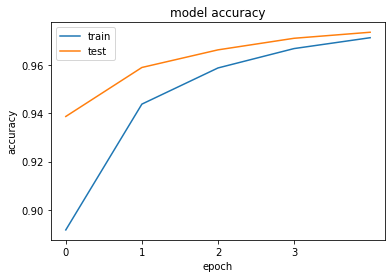

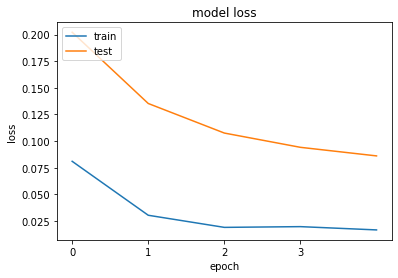

In [8]:
# summarize history for accuracy
plt.plot(training_acc_history)
plt.plot(testing_acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(range(0,4))
plt.show()
# summarize history for loss
plt.plot(training_loss_history)
plt.plot(testing_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(range(0,4))
plt.show()

Visualize prediction

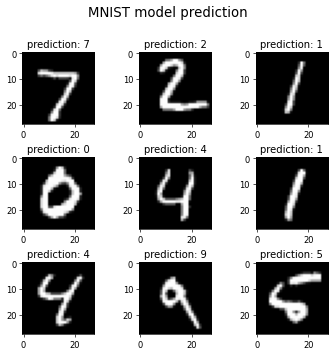

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x_test, y_test = next(iter(test_loader))
x_test = torch.squeeze(x_test, dim=1)

width=4
height=4
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(6, 6), dpi=60)

fig.suptitle('MNIST model prediction', fontsize=16)
logits = model(x_test[:rows*cols])
y_preds = logits.argmax(dim=1, keepdim=True)
for i in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("prediction: "+str(y_preds[i].numpy()[0]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
fig.tight_layout()    
plt.subplots_adjust(top=0.85)
plt.show()

Save the trained model 

In [10]:
save_model_name = "mnist.pt"
torch.save(model.state_dict(), save_model_name)

Convert the pt model to onnx model

In [11]:
inputs = torch.randn(64, 1, 28, 28)
out = model(inputs)
torch.onnx.export(model,
                  inputs,
                  'mnist.onnx',
                  opset_version=8,
                  example_outputs=out)